<a href="https://colab.research.google.com/github/Gopikuppala7/MachineLearning/blob/main/CNN_Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [ ]:
# Define the path to the dataset directory
dataset_path = '/content/drive/MyDrive/MLPR'

In [ ]:
#defining the image height and width
batch_size = 32
image_size = (160, 160)

In [ ]:
# Load the entire dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    batch_size=batch_size,
    image_size=(160,160),
)

Found 1938 files belonging to 6 classes.


In [ ]:
# Load the training data
trainset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    batch_size=batch_size,
    image_size=(160, 160),
    seed=123,
    validation_split=0.2,  # 80% training, 20% validation
    subset='training'      # Subset for training data
)

Found 1938 files belonging to 6 classes.
Using 1551 files for training.


In [ ]:
# Load the validation data
validationset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    batch_size=batch_size,
    image_size=(160, 160),
    seed=123,
    validation_split=0.2,  # 80% training, 20% validation
    subset='validation'   # Subset for validation data
)

Found 1938 files belonging to 6 classes.
Using 387 files for validation.


In [ ]:
#printing the classes in the MLPR folder
class_labels = dataset.class_names
print(class_labels)

['Background', 'Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5']


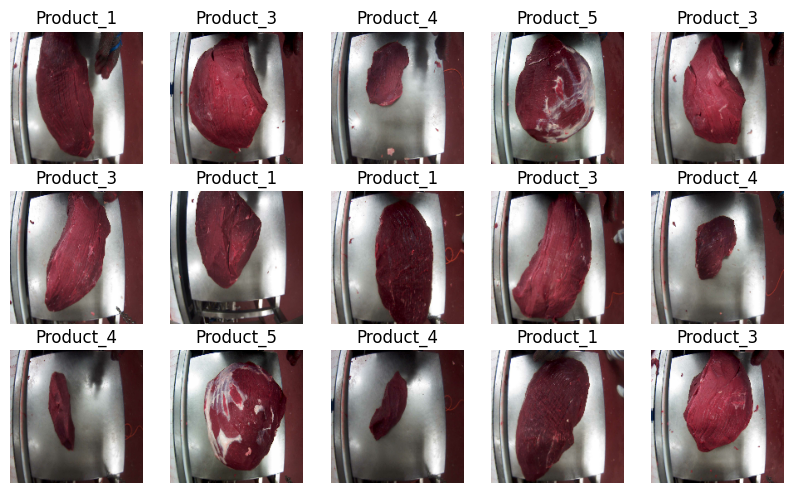

In [ ]:
#Shows the first 15 images and labels from the training set:
class_names = trainset.class_names

plt.figure(figsize=(10, 10))
for images, labels in trainset.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validationset)
test_dataset = validationset.take(val_batches // 5)
validation_dataset = validationset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [ ]:
#Configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = trainset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validationset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

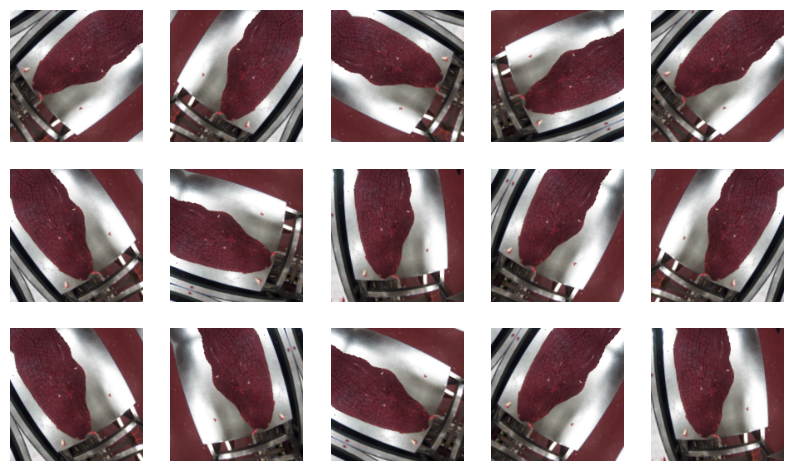

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


**Convolutional Neural Network (CNN) **

In [ ]:
#Create the convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#Add Dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 79, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 36, 36, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 82944)            

In [ ]:
#Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn_history = model.fit(trainset, epochs=10,
                    validation_data=validationset)

Epoch 1/10
49/49 [==============================] - 91s 2s/step - loss: 23.6618 - accuracy: 0.6499 - val_loss: 0.3407 - val_accuracy: 0.9096
Epoch 2/10
49/49 [==============================] - 94s 2s/step - loss: 0.2846 - accuracy: 0.9014 - val_loss: 0.3446 - val_accuracy: 0.8811
Epoch 3/10
49/49 [==============================] - 90s 2s/step - loss: 0.2063 - accuracy: 0.9336 - val_loss: 0.3678 - val_accuracy: 0.8760
Epoch 4/10
49/49 [==============================] - 89s 2s/step - loss: 0.1583 - accuracy: 0.9465 - val_loss: 0.3832 - val_accuracy: 0.8811
Epoch 5/10
49/49 [==============================] - 91s 2s/step - loss: 0.1541 - accuracy: 0.9574 - val_loss: 0.2638 - val_accuracy: 0.9380
Epoch 6/10
49/49 [==============================] - 94s 2s/step - loss: 0.0347 - accuracy: 0.9884 - val_loss: 0.3020 - val_accuracy: 0.9070
Epoch 7/10
49/49 [==============================] - 100s 2s/step - loss: 0.0972 - accuracy: 0.9742 - val_loss: 0.5924 - val_accuracy: 0.8630
Epoch 8/10
49/49 [

In [ ]:
#Freeze the convolutional base
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
#Adding a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

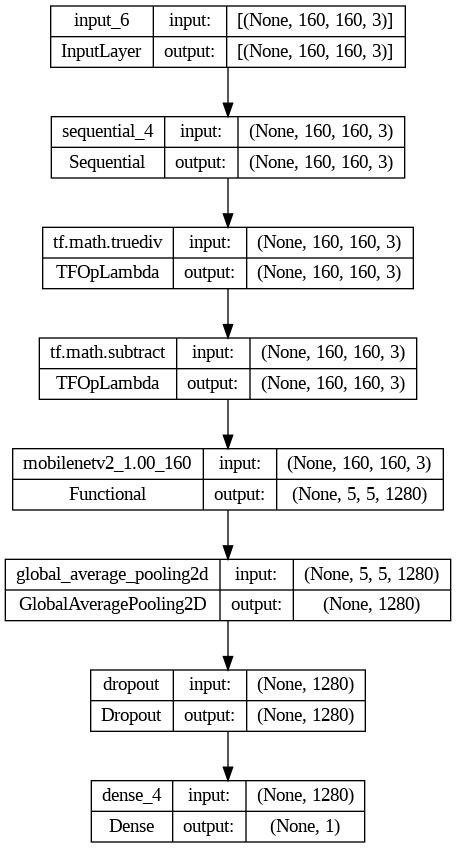

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#compile the Transfer Learning model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
initial_epochs = 10

loss1, accuracy1 = model.evaluate(validationset)
print("initial loss: {:.2f}".format(loss1))
print("initial accuracy: {:.2f}".format(accuracy1))

13/13 [==============================] - 8s 429ms/step - loss: 0.2713 - accuracy: 0.9380
initial loss: 0.27
initial accuracy: 0.94


In [ ]:
history = model.fit(trainset,
                    epochs=initial_epochs,
                    validation_data=validationset)

Epoch 1/10
49/49 [==============================] - 90s 2s/step - loss: 0.6993 - accuracy: 0.8285 - val_loss: 0.8202 - val_accuracy: 0.8114
Epoch 2/10
49/49 [==============================] - 94s 2s/step - loss: 0.2170 - accuracy: 0.9375 - val_loss: 0.5394 - val_accuracy: 0.8501
Epoch 3/10
49/49 [==============================] - 91s 2s/step - loss: 0.0717 - accuracy: 0.9755 - val_loss: 0.5085 - val_accuracy: 0.8630
Epoch 4/10
49/49 [==============================] - 92s 2s/step - loss: 0.0253 - accuracy: 0.9897 - val_loss: 0.5574 - val_accuracy: 0.8915
Epoch 5/10
49/49 [==============================] - 93s 2s/step - loss: 0.0114 - accuracy: 0.9968 - val_loss: 0.5634 - val_accuracy: 0.8811
Epoch 6/10
49/49 [==============================] - 92s 2s/step - loss: 0.0158 - accuracy: 0.9961 - val_loss: 0.5199 - val_accuracy: 0.8941
Epoch 7/10
49/49 [==============================] - 90s 2s/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.5121 - val_accuracy: 0.8863
Epoch 8/10
49/49 [==

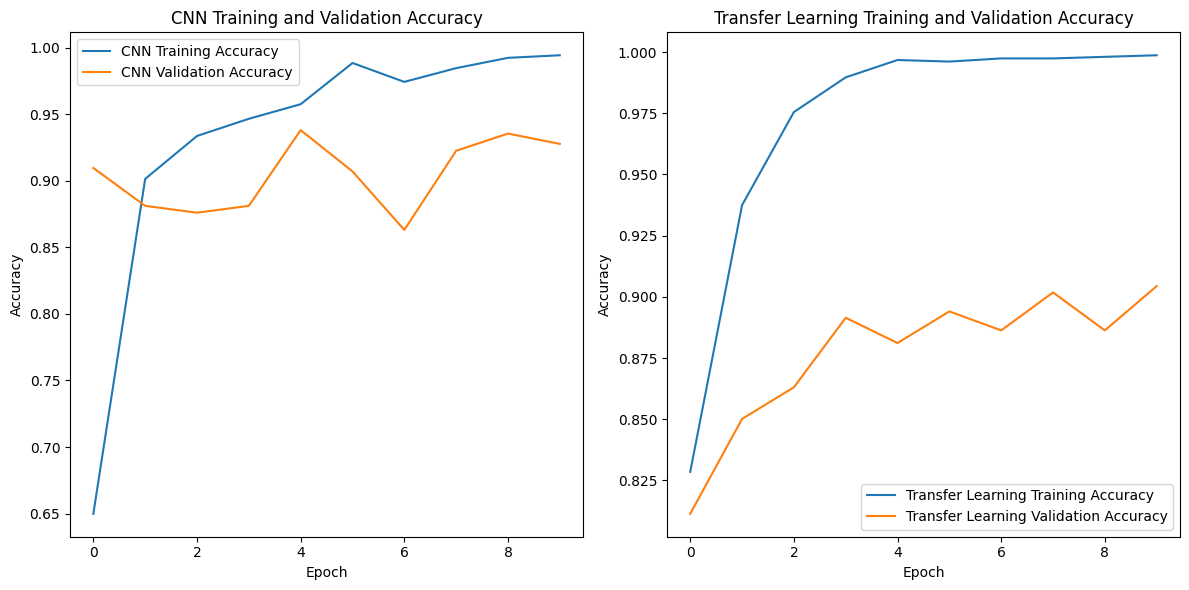

In [ ]:
#comparing the cnn & Transfer learning
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Transfer Learning Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Transfer Learning Validation Accuracy')
plt.title('Transfer Learning Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

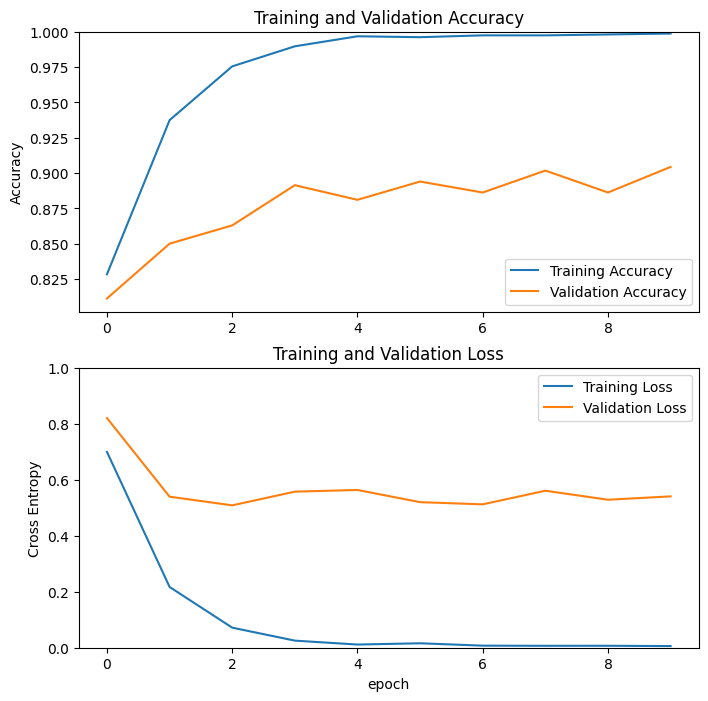

In [ ]:
#training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Fine tuning
#Un-freeze the top layers of the model
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 79, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 36, 36, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 82944)            

In [ ]:
len(model.trainable_variables)

10

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(trainset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validationset)

Epoch 11/20
49/49 [==============================] - 90s 2s/step - loss: 7.1581 - accuracy: 0.1401 - val_loss: 6.0059 - val_accuracy: 0.1506
Epoch 12/20
49/49 [==============================] - 90s 2s/step - loss: 5.0741 - accuracy: 0.1443 - val_loss: 4.4212 - val_accuracy: 0.1545
Epoch 13/20
49/49 [==============================] - 90s 2s/step - loss: 3.6299 - accuracy: 0.1480 - val_loss: 2.9814 - val_accuracy: 0.1579
Epoch 14/20
49/49 [==============================] - 92s 2s/step - loss: 1.8311 - accuracy: 0.1532 - val_loss: 0.3940 - val_accuracy: 0.1628
Epoch 15/20
49/49 [==============================] - 89s 2s/step - loss: -1.2682 - accuracy: 0.1569 - val_loss: -3.0412 - val_accuracy: 0.1667
Epoch 16/20
49/49 [==============================] - 90s 2s/step - loss: -3.6432 - accuracy: 0.1595 - val_loss: -4.9014 - val_accuracy: 0.1693
Epoch 17/20
49/49 [==============================] - 95s 2s/step - loss: -4.9555 - accuracy: 0.1627 - val_loss: -5.8213 - val_accuracy: 0.1705
Epoch 1

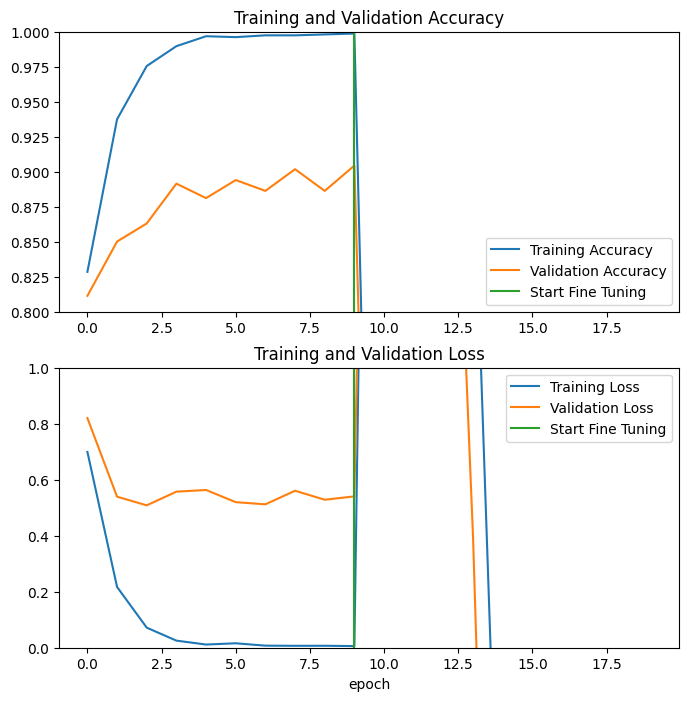

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
#Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 4s 804ms/step - loss: -9.3842 - accuracy: 0.1766
Test accuracy : 0.17656250298023224


Predictions:
 [1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1
 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1
 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0]
Labels:
 [5 5 5 4 5 4 5 3 1 4 5 1 1 1 3 1 1 1 5 5 1 5 5 3 5 4 5 5 4 1 1 1]


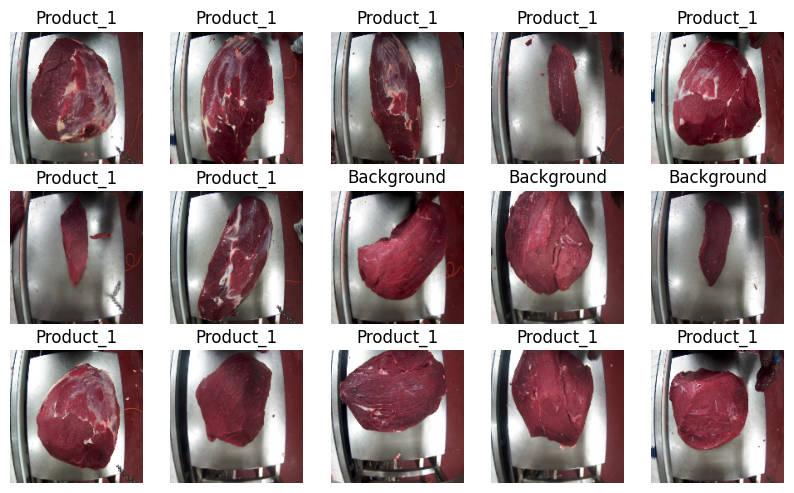

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(15):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")